# Groceries Product Recommendation Using Market Basket Analysis

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import re
import time
import math
import itertools
import numpy                      as np
import pandas                     as pd
import seaborn                    as sns
import plotly.express             as px
import matplotlib.pyplot          as plt

In [3]:
from   pyforest                   import *
from   pyECLAT                    import ECLAT
from   mlxtend.preprocessing      import TransactionEncoder
from   mlxtend.frequent_patterns  import apriori, association_rules, fpgrowth

In [4]:
df = pd.read_csv('C:/Users/ASUS/kode/projek/16. Market Basket Analysis/dataset/Retail_Transactions_Dataset3.csv')

<IPython.core.display.Javascript object>

In [5]:
df

Transaction_ID         Date      Customer_Name  \
0          1000000000  44582.26875       Stacey Price   
1          1000000001  44986.54236   Michelle Carlson   
2          1000000002  45372.65069        Lisa Graves   
3          1000000003  44135.41597  Mrs. Patricia May   
4          1000000004  44175.04097     Susan Mitchell   
...               ...          ...                ...   
21641      1000021641  44047.74097       Sandra Greer   
21642      1000021642  43913.85486   Carrie Wilkinson   
21643      1000021643  44340.69792        Neil Barber   
21644      1000021644  44348.24931     Amber Anderson   
21645      1000021645  44306.94792       Karen Glover   

                                                 Product  Total_Items  \
0            ['Ketchup', 'Shaving Cream', 'Light Bulbs']            3   
1      ['Ice Cream', 'Milk', 'Olive Oil', 'Bread', 'P...            2   
2                                            ['Spinach']            6   
3                                 ['Tissues', 'Mustard']            1   
4                                          ['Dish Soap']           10   
...                                                  ...          ...   
21641                             ['Soap', 'Toothbrush']            4   
21642  ['Cleaning Rags', 'BBQ Sauce', 'Vacuum Cleaner...            3   
21643  ['Dustpan', 'Ironing Board', 'Vacuum Cleaner',...            4   
21644                                ['Tuna', 'Pickles']            1   
21645            ['Dishware', 'Ironing Board', 'Coffee']            4   

       Total_Cost  Payment_Method           City        Store_Type  \
0           71.65  Mobile Payment    Los Angeles    Warehouse Club   
1           25.93            Cash  San Francisco   Specialty Store   
2           41.49     Credit Card        Houston  Department Store   
3           39.34  Mobile Payment        Chicago          Pharmacy   
4           16.42      Debit Card        Houston   Specialty Store   
...           ...             ...            ...               ...   
21641       47.48     Credit Card         Dallas          Pharmacy   
21642       45.28  Mobile Payment        Atlanta  Department Store   
21643       49.72     Credit Card        Atlanta   Specialty Store   
21644       93.88  Mobile Payment         Dallas       Supermarket   
21645       96.74            Cash  San Francisco   Specialty Store   

       Discount_Applied Customer_Category  Season                   Promotion  
0                  True         Homemaker  Winter                         NaN  
1                  True      Professional    Fall      BOGO (Buy One Get One)  
2                  True      Professional  Winter                         NaN  
3                  True         Homemaker  Spring                         NaN  
4                 False       Young Adult  Winter  Discount on Selected Items  
...                 ...               ...     ...                         ...  
21641              True      Professional  Summer                         NaN  
21642              True       Middle-Aged  Summer  Discount on Selected Items  
21643             False          Teenager  Summer                         NaN  
21644              True    Senior Citizen  Summer      BOGO (Buy One Get One)  
21645             False      Professional    Fall      BOGO (Buy One Get One)  

[21646 rows x 13 columns]

In [75]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21646 entries, 0 to 21645
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Transaction_ID     21646 non-null  int64  
 1   Date               21646 non-null  float64
 2   Customer_Name      21646 non-null  object 
 3   Product            21646 non-null  object 
 4   Total_Items        21646 non-null  int64  
 5   Total_Cost         21646 non-null  float64
 6   Payment_Method     21646 non-null  object 
 7   City               21646 non-null  object 
 8   Store_Type         21646 non-null  object 
 9   Discount_Applied   21646 non-null  bool   
 10  Customer_Category  21646 non-null  object 
 11  Season             21646 non-null  object 
 12  Promotion          14430 non-null  object 
dtypes: bool(1), float64(2), int64(2), object(8)
memory usage: 2.0+ MB


Akan memilih atau menggunakan variabel 'Product' saja, karena aku membutuhkan data yang bisa dijadikan secara vertikal nantinya.

In [6]:
df2 = df[['Product']]
df2

Product
0            ['Ketchup', 'Shaving Cream', 'Light Bulbs']
1      ['Ice Cream', 'Milk', 'Olive Oil', 'Bread', 'P...
2                                            ['Spinach']
3                                 ['Tissues', 'Mustard']
4                                          ['Dish Soap']
...                                                  ...
21641                             ['Soap', 'Toothbrush']
21642  ['Cleaning Rags', 'BBQ Sauce', 'Vacuum Cleaner...
21643  ['Dustpan', 'Ironing Board', 'Vacuum Cleaner',...
21644                                ['Tuna', 'Pickles']
21645            ['Dishware', 'Ironing Board', 'Coffee']

[21646 rows x 1 columns]

In [7]:
df2['Product'] = df2['Product'].apply(lambda x: x.strip("[]").replace("'", ""))

In [8]:
df2.head(5)

Product
0          Ketchup, Shaving Cream, Light Bulbs
1  Ice Cream, Milk, Olive Oil, Bread, Potatoes
2                                      Spinach
3                             Tissues, Mustard
4                                    Dish Soap

In [9]:
df3 = df2['Product'].str.split(', ', expand=True)

In [10]:
df3

0              1               2       3         4
0            Ketchup  Shaving Cream     Light Bulbs    None      None
1          Ice Cream           Milk       Olive Oil   Bread  Potatoes
2            Spinach           None            None    None      None
3            Tissues        Mustard            None    None      None
4          Dish Soap           None            None    None      None
...              ...            ...             ...     ...       ...
21641           Soap     Toothbrush            None    None      None
21642  Cleaning Rags      BBQ Sauce  Vacuum Cleaner    Soda      None
21643        Dustpan  Ironing Board  Vacuum Cleaner  Yogurt      None
21644           Tuna        Pickles            None    None      None
21645       Dishware  Ironing Board          Coffee    None      None

[21646 rows x 5 columns]

In [11]:
df3.tail()

0              1               2       3     4
21641           Soap     Toothbrush            None    None  None
21642  Cleaning Rags      BBQ Sauce  Vacuum Cleaner    Soda  None
21643        Dustpan  Ironing Board  Vacuum Cleaner  Yogurt  None
21644           Tuna        Pickles            None    None  None
21645       Dishware  Ironing Board          Coffee    None  None

In [12]:
df3.shape

(21646, 5)

In [13]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21646 entries, 0 to 21645
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       21646 non-null  object
 1   1       17329 non-null  object
 2   2       13002 non-null  object
 3   3       8594 non-null   object
 4   4       4325 non-null   object
dtypes: object(5)
memory usage: 845.7+ KB


### Exploratory Data Analysiss (EDA)

#### Barang belanja yang duplikat atau membeli produk yang sama

In [14]:
items_total = df3.apply(pd.Series.value_counts).sum(axis=1)
items_total = pd.DataFrame({'items': items_total.index, 'transactions': items_total.values})

items_total.sort_values('transactions',
                        ascending=False).head(20).reset_index(drop=True).style.background_gradient(cmap='Greens')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [15]:
# Mencari duplikat

df3['jml_dup']       = df3.iloc[:, 0:4].apply(pd.Series.nunique, axis=1) # ada kata yang mirip
df3['jml_produk']    = df3.iloc[:, 0:4].count(axis=1) # jumlah barang

<IPython.core.display.Javascript object>

In [16]:
print('Banyaknya transaksi yang mengandung item duplikat adalah:', len(df3[df3['jml_dup'] != df3['jml_produk']]))

Banyaknya transaksi yang mengandung item duplikat adalah: 851


In [17]:
df3

0              1               2       3         4  \
0            Ketchup  Shaving Cream     Light Bulbs    None      None   
1          Ice Cream           Milk       Olive Oil   Bread  Potatoes   
2            Spinach           None            None    None      None   
3            Tissues        Mustard            None    None      None   
4          Dish Soap           None            None    None      None   
...              ...            ...             ...     ...       ...   
21641           Soap     Toothbrush            None    None      None   
21642  Cleaning Rags      BBQ Sauce  Vacuum Cleaner    Soda      None   
21643        Dustpan  Ironing Board  Vacuum Cleaner  Yogurt      None   
21644           Tuna        Pickles            None    None      None   
21645       Dishware  Ironing Board          Coffee    None      None   

       jml_dup  jml_produk  
0            3           3  
1            4           4  
2            1           1  
3            2           2  
4            1           1  
...        ...         ...  
21641        2           2  
21642        4           4  
21643        4           4  
21644        2           2  
21645        3           3  

[21646 rows x 7 columns]

In [18]:
df_bersih = df3[df3['jml_dup'] == df3['jml_produk']].iloc[:, 0:5]

In [19]:
print('Banyaknya transaksi yang tidak mengandung item duplikat adalah:', len(df_bersih))

Banyaknya transaksi yang tidak mengandung item duplikat adalah: 20795


In [20]:
df_bersih

0              1               2       3         4
0            Ketchup  Shaving Cream     Light Bulbs    None      None
1          Ice Cream           Milk       Olive Oil   Bread  Potatoes
2            Spinach           None            None    None      None
3            Tissues        Mustard            None    None      None
4          Dish Soap           None            None    None      None
...              ...            ...             ...     ...       ...
21641           Soap     Toothbrush            None    None      None
21642  Cleaning Rags      BBQ Sauce  Vacuum Cleaner    Soda      None
21643        Dustpan  Ironing Board  Vacuum Cleaner  Yogurt      None
21644           Tuna        Pickles            None    None      None
21645       Dishware  Ironing Board          Coffee    None      None

[20795 rows x 5 columns]

In [21]:
df_bersih = df_bersih.fillna(value= float('nan'))
df_bersih

0              1               2       3         4
0            Ketchup  Shaving Cream     Light Bulbs     NaN       NaN
1          Ice Cream           Milk       Olive Oil   Bread  Potatoes
2            Spinach            NaN             NaN     NaN       NaN
3            Tissues        Mustard             NaN     NaN       NaN
4          Dish Soap            NaN             NaN     NaN       NaN
...              ...            ...             ...     ...       ...
21641           Soap     Toothbrush             NaN     NaN       NaN
21642  Cleaning Rags      BBQ Sauce  Vacuum Cleaner    Soda       NaN
21643        Dustpan  Ironing Board  Vacuum Cleaner  Yogurt       NaN
21644           Tuna        Pickles             NaN     NaN       NaN
21645       Dishware  Ironing Board          Coffee     NaN       NaN

[20795 rows x 5 columns]

In [22]:
items_total_bersih = df_bersih.apply(pd.Series.value_counts).sum(axis=1)
items_total_bersih = pd.DataFrame({'item': items_total_bersih.index, 'transaksi': items_total_bersih.values})

items_total_bersih.sort_values('transaksi',
                               ascending=False).head(15).reset_index(drop = True).style.background_gradient(cmap='Greens')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Menganalisis Produk

In [23]:
warnings.filterwarnings("ignore", category=DeprecationWarning)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

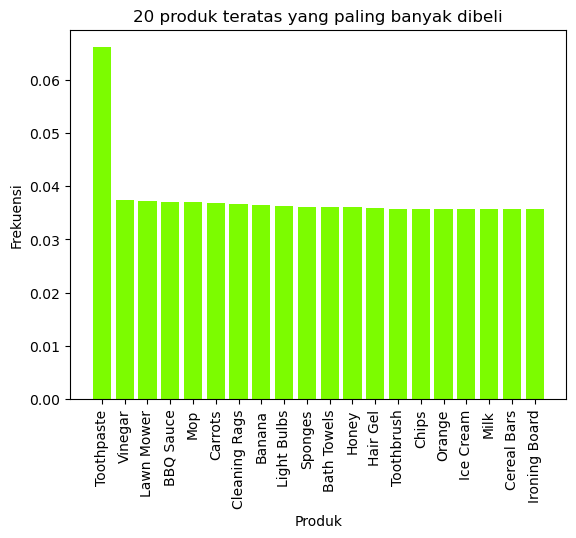

In [24]:
jumlah_produk    = df_bersih.apply(pd.Series.value_counts)
total_sampel     = len(df)
frekuensi_produk = jumlah_produk / total_sampel
produk_top       = frekuensi_produk.sum(axis=1).sort_values(ascending=False).head(20)

plt.bar(produk_top.index, produk_top.values, color='#7CFC00')
plt.xlabel('Produk')
plt.ylabel('Frekuensi')
plt.title('20 produk teratas yang paling banyak dibeli')
plt.xticks(rotation=90)
plt.show()

In [25]:
items_total_bersih['semua'] = "Tree Map"
items_total_bersih          = items_total_bersih.sort_values('transaksi', ascending=False)

fig = px.treemap(items_total_bersih.head(50),
                 path       = ['semua', "item"],
                 values     = 'transaksi',
                 color      = items_total_bersih["transaksi"].head(50),
                 hover_data = ['item'],
                 title      = "Peta Pohon berisi 50 produk teratas yang paling banyak muncul di keranjang belanja")
                 color_continuous_scale ='Greens',
fig.show()

<IPython.core.display.Javascript object>

### Melakukan analisis frekuensi atau transaksi belanjaan
Melihat berapa produk yang dibeli dalam satu kali proses belanja

In [26]:
produk_per_transaksi = df_bersih.count(axis=1)
produk_per_transaksi = produk_per_transaksi.value_counts()
produk_per_transaksi

1    4317
2    4277
3    4244
5    4023
4    3934
Name: count, dtype: int64

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'Jumlah produk yang dibeli dalam satu kali proses belanja')

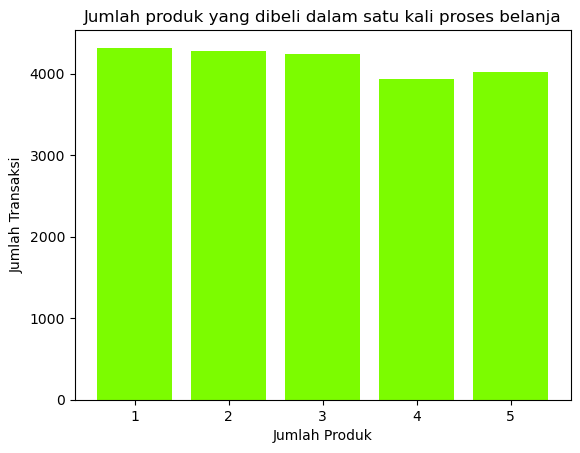

In [27]:
plt.bar(produk_per_transaksi.index, produk_per_transaksi.values, color='#7CFC00')
plt.xlabel('Jumlah Produk')
plt.ylabel('Jumlah Transaksi')
plt.title('Jumlah produk yang dibeli dalam satu kali proses belanja')

### Market Basket Analisis
Mencoba 3 algoritma berbeda:
- ECLAT (Equivalence Class Clustering and bottom-up Lattice Traversal)
- Apriori
- FP-Growth (Frequent Pattern Growth)


#### SImple explanation
**Market basket analysis** adalah teknik yang digunakan dalam bisnis ritel dan e-commerce untuk dan mengidentifikasi hubungan antara produk yang sering dibeli bersamaan. 

Dengan mengidentifikasi produk yang sering dibeli bersamaan, bisnis dapat mengoptimalkan penempatan produk, membuat promosi yang ditargetkan, dan meningkatkan pengalaman pelanggan.


**Associate Rule Mining** adalah teknik yang digunakan untuk mencari asosiasi antara satu item dengan item lainnya.

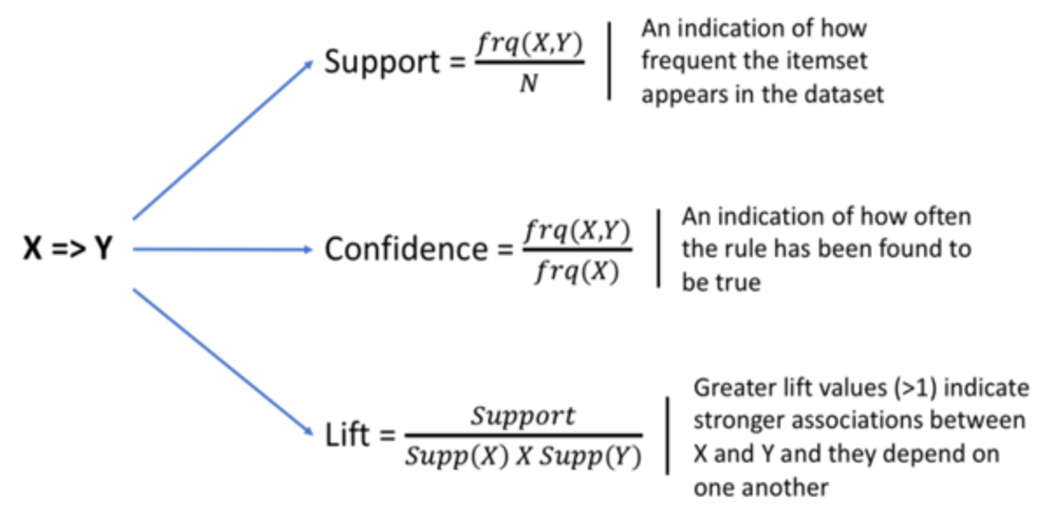

- Support (s): Mengukur seberapa sering suatu item atau kombinasi item muncul dalam dataset.
- Confidence (c): Mengukur seberapa sering item B muncul dalam transaksi yang mengandung item A.
- Lift (l): Mengukur seberapa banyak item B lebih mungkin dibeli ketika item A dibeli, dibandingkan dengan item B dibeli sendiri.
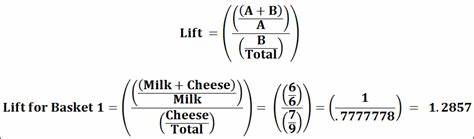

#### Insight
- Gunakan support yang lebih tinggi untuk mengidentifikasi set item yang umum dibeli.
- Gunakan confidence yang lebih tinggi untuk mengidentifikasi hubungan bersyarat yang kuat antar item.
- Gunakan lift yang lebih tinggi untuk mengidentifikasi itemset di mana pembelian bersama lebih sering terjadi daripada yang diharapkan secara kebetulan.

Semakin besar nilai support maka akan semakin besar menghitung hubungan-hubungan yang jarang dilakukan. (semakin buruk)


In [28]:
# menentukan s dan c minimal

min_supp = eval(input("Masukkan nilai support (s) minimum: ")) #0.001
min_conf = eval(input("Masukkan nilai confidence (c) minimum: ")) #0.01

Masukkan nilai support (s) minimum: 0.001
Masukkan nilai confidence (c) minimum: 0.01


### ECLAT

In [29]:
df_bersih = df_bersih.reset_index(drop=True)

In [30]:
df_bersih

0              1               2       3         4
0            Ketchup  Shaving Cream     Light Bulbs     NaN       NaN
1          Ice Cream           Milk       Olive Oil   Bread  Potatoes
2            Spinach            NaN             NaN     NaN       NaN
3            Tissues        Mustard             NaN     NaN       NaN
4          Dish Soap            NaN             NaN     NaN       NaN
...              ...            ...             ...     ...       ...
20790           Soap     Toothbrush             NaN     NaN       NaN
20791  Cleaning Rags      BBQ Sauce  Vacuum Cleaner    Soda       NaN
20792        Dustpan  Ironing Board  Vacuum Cleaner  Yogurt       NaN
20793           Tuna        Pickles             NaN     NaN       NaN
20794       Dishware  Ironing Board          Coffee     NaN       NaN

[20795 rows x 5 columns]

In [31]:
# mengubah struktur data menjadi setiap produk sebagai variabelnya
# setiap record data mewakili satu transaksi produk

df4   = df_bersih.copy()
eclat = ECLAT(data=df4)

In [32]:
eclat.df_bin # fungsi binari

Dustpan  BBQ Sauce  Sponges  Yogurt  Canned Soup  Bread  Chips  Syrup  \
0            0          0        0       0            0      0      0      0   
1            0          0        0       0            0      1      0      0   
2            0          0        0       0            0      0      0      0   
3            0          0        0       0            0      0      0      0   
4            0          0        0       0            0      0      0      0   
...        ...        ...      ...     ...          ...    ...    ...    ...   
20790        0          0        0       0            0      0      0      0   
20791        0          1        0       0            0      0      0      0   
20792        1          0        0       1            0      0      0      0   
20793        0          0        0       0            0      0      0      0   
20794        0          0        0       0            0      0      0      0   

       Soda  Dishware  ...  Hand Sanitizer  Diapers  Beef  Orange  Deodorant  \
0         0         0  ...               0        0     0       0          0   
1         0         0  ...               0        0     0       0          0   
2         0         0  ...               0        0     0       0          0   
3         0         0  ...               0        0     0       0          0   
4         0         0  ...               0        0     0       0          0   
...     ...       ...  ...             ...      ...   ...     ...        ...   
20790     0         0  ...               0        0     0       0          0   
20791     1         0  ...               0        0     0       0          0   
20792     0         0  ...               0        0     0       0          0   
20793     0         0  ...               0        0     0       0          0   
20794     0         1  ...               0        0     0       0          0   

       Peanut Butter  Cleaning Spray  Dish Soap  Feminine Hygiene Products  \
0                  0               0          0                          0   
1                  0               0          0                          0   
2                  0               0          0                          0   
3                  0               0          0                          0   
4                  0               0          1                          0   
...              ...             ...        ...                        ...   
20790              0               0          0                          0   
20791              0               0          0                          0   
20792              0               0          0                          0   
20793              0               0          0                          0   
20794              0               0          0                          0   

       Mayonnaise  
0               0  
1               0  
2               0  
3               0  
4               0  
...           ...  
20790           0  
20791           0  
20792           0  
20793           0  
20794           0  

[20795 rows x 82 columns]

In [33]:
# suatu produk yang punya paling banyak kombinasi 1 sampai 2 produk

# menghitung seberapa lama proses pelatihan terhadap Eclat
waktu_mulai         = time.time()

min_kombinasi       = 1
max_kombinasi       = 2

rule_indices, rule_supports = eclat.fit(min_support     = min_supp, # (s)
                                        min_combination = min_kombinasi,
                                        max_combination = max_kombinasi,
                                        separator       = ', ',
                                        verbose         = True)

# waktu eksekusi untuk mencari kompleksitas waktu
waktu_eksekusi_eclat = time.time() - waktu_mulai

Combination 1 by 1


81it [00:02, 35.63it/s]


Combination 2 by 2


3240it [01:16, 42.62it/s]


In [34]:
# melihat aturan/rule yang memiliki kombinasi
rule_indices

{'Dustpan': [18,
  41,
  42,
  43,
  57,
  58,
  60,
  61,
  96,
  134,
  190,
  208,
  277,
  304,
  317,
  349,
  363,
  400,
  422,
  438,
  439,
  468,
  529,
  595,
  603,
  619,
  681,
  806,
  820,
  855,
  870,
  894,
  921,
  927,
  982,
  1048,
  1082,
  1104,
  1135,
  1147,
  1161,
  1177,
  1199,
  1231,
  1234,
  1237,
  1252,
  1273,
  1274,
  1346,
  1381,
  1413,
  1442,
  1493,
  1570,
  1575,
  1592,
  1666,
  1685,
  1710,
  1771,
  1780,
  1838,
  1859,
  1882,
  1893,
  1931,
  1936,
  1978,
  1996,
  2008,
  2014,
  2034,
  2097,
  2128,
  2130,
  2194,
  2208,
  2239,
  2286,
  2317,
  2326,
  2410,
  2495,
  2508,
  2517,
  2532,
  2707,
  2730,
  2731,
  2744,
  2793,
  2806,
  2812,
  2881,
  2901,
  2941,
  2951,
  2979,
  2997,
  3007,
  3009,
  3015,
  3019,
  3053,
  3098,
  3161,
  3188,
  3195,
  3286,
  3301,
  3327,
  3371,
  3421,
  3427,
  3532,
  3566,
  3570,
  3588,
  3592,
  3630,
  3643,
  3670,
  3681,
  3764,
  3777,
  3782,
  3863,
  3868,
 

### Tujuan eclat
Mengekstrak aturan asosiasi yang signifikan dari item-item yang sering muncul dalam dataset tersebut.

In [35]:
itemset = []

for i in list(rule_supports.keys()):
    i = i.split(', ')
    i = frozenset(i)
    itemset.append(i)

frek_itemset = pd.DataFrame({'support': list(rule_supports.values()), 
                             'itemsets': itemset})

frek_itemset

<IPython.core.display.Javascript object>

support                                     itemsets
0     0.034816                                    (Dustpan)
1     0.038519                                  (BBQ Sauce)
2     0.037509                                    (Sponges)
3     0.036163                                     (Yogurt)
4     0.036547                                (Canned Soup)
...        ...                                          ...
2578  0.001250  (Feminine Hygiene Products, Cleaning Spray)
2579  0.001058                 (Cleaning Spray, Mayonnaise)
2580  0.001202       (Dish Soap, Feminine Hygiene Products)
2581  0.001202                      (Dish Soap, Mayonnaise)
2582  0.001202      (Feminine Hygiene Products, Mayonnaise)

[2583 rows x 2 columns]

In [36]:
rule_ECLAT = association_rules(frek_itemset, 
                               metric="confidence", 
                               min_threshold=min_conf)

rule_ECLAT = rule_ECLAT[rule_ECLAT.lift > 1]
rule_ECLAT = rule_ECLAT.reset_index(drop=True)
rule_ECLAT

antecedents                  consequents  \
0                   (Canned Soup)                    (Dustpan)   
1                       (Dustpan)                (Canned Soup)   
2                         (Bread)                    (Dustpan)   
3                       (Dustpan)                      (Bread)   
4                         (Chips)                    (Dustpan)   
...                           ...                          ...   
1773             (Cleaning Spray)              (Peanut Butter)   
1774              (Peanut Butter)  (Feminine Hygiene Products)   
1775  (Feminine Hygiene Products)              (Peanut Butter)   
1776              (Peanut Butter)                 (Mayonnaise)   
1777                 (Mayonnaise)              (Peanut Butter)   

      antecedent support  consequent support   support  confidence      lift  \
0               0.036547            0.034816  0.001346    0.036842  1.058193   
1               0.034816            0.036547  0.001346    0.038674  1.058193   
2               0.035730            0.034816  0.001491    0.041723  1.198376   
3               0.034816            0.035730  0.001491    0.042818  1.198376   
4               0.036980            0.034816  0.001298    0.035111  1.008458   
...                  ...                 ...       ...         ...       ...   
1773            0.036643            0.034960  0.001346    0.036745  1.051060   
1774            0.034960            0.036595  0.001491    0.042641  1.165203   
1775            0.036595            0.034960  0.001491    0.040736  1.165203   
1776            0.034960            0.035201  0.001395    0.039890  1.133213   
1777            0.035201            0.034960  0.001395    0.039617  1.133213   

      leverage  conviction  zhangs_metric  
0     0.000074    1.002104       0.057079  
1     0.000074    1.002212       0.056976  
2     0.000247    1.007207       0.171671  
3     0.000247    1.007405       0.171509  
4     0.000011    1.000305       0.008709  
...        ...         ...            ...  
1773  0.000065    1.001853       0.050428  
1774  0.000211    1.006315       0.146917  
1775  0.000211    1.006021       0.147166  
1776  0.000164    1.004884       0.121812  
1777  0.000164    1.004849       0.121842  

[1778 rows x 10 columns]

### Apriori

In [37]:
df5 = df_bersih.replace(np.nan, None)
df5

<IPython.core.display.Javascript object>

0              1               2       3         4
0            Ketchup  Shaving Cream     Light Bulbs    None      None
1          Ice Cream           Milk       Olive Oil   Bread  Potatoes
2            Spinach           None            None    None      None
3            Tissues        Mustard            None    None      None
4          Dish Soap           None            None    None      None
...              ...            ...             ...     ...       ...
20790           Soap     Toothbrush            None    None      None
20791  Cleaning Rags      BBQ Sauce  Vacuum Cleaner    Soda      None
20792        Dustpan  Ironing Board  Vacuum Cleaner  Yogurt      None
20793           Tuna        Pickles            None    None      None
20794       Dishware  Ironing Board          Coffee    None      None

[20795 rows x 5 columns]

mencoba menggunakan teknik encoding/binari baru selain one hot sebelumnya, yaitu:

**Transaction Encoder**: Teknik encoding yang cocok digunakan ketika ingin menerapkannya pada algoritma Apriori. TransactionEncoder akan menerjemahkan setiap transaksi (baris data) menjadi vektor biner, di mana setiap kolom vektor mewakili keberadaan atau ketiadaan item tertentu dalam transaksi.


In [38]:
# Membuat daftar array list kumpulan item yang berisi item yang dibeli pelanggan

transaksi = []

for _, row in df5.iterrows():
    temp = []
    
    for column, value in row.items():
        
        if value is not None:
            i = f"{value}"
            temp.append(i)
        transaksi.append(temp)

In [39]:
transaksi

[['Ketchup', 'Shaving Cream', 'Light Bulbs'],
 ['Ketchup', 'Shaving Cream', 'Light Bulbs'],
 ['Ketchup', 'Shaving Cream', 'Light Bulbs'],
 ['Ketchup', 'Shaving Cream', 'Light Bulbs'],
 ['Ketchup', 'Shaving Cream', 'Light Bulbs'],
 ['Ice Cream', 'Milk', 'Olive Oil', 'Bread', 'Potatoes'],
 ['Ice Cream', 'Milk', 'Olive Oil', 'Bread', 'Potatoes'],
 ['Ice Cream', 'Milk', 'Olive Oil', 'Bread', 'Potatoes'],
 ['Ice Cream', 'Milk', 'Olive Oil', 'Bread', 'Potatoes'],
 ['Ice Cream', 'Milk', 'Olive Oil', 'Bread', 'Potatoes'],
 ['Spinach'],
 ['Spinach'],
 ['Spinach'],
 ['Spinach'],
 ['Spinach'],
 ['Tissues', 'Mustard'],
 ['Tissues', 'Mustard'],
 ['Tissues', 'Mustard'],
 ['Tissues', 'Mustard'],
 ['Tissues', 'Mustard'],
 ['Dish Soap'],
 ['Dish Soap'],
 ['Dish Soap'],
 ['Dish Soap'],
 ['Dish Soap'],
 ['Toothpaste', 'Chicken'],
 ['Toothpaste', 'Chicken'],
 ['Toothpaste', 'Chicken'],
 ['Toothpaste', 'Chicken'],
 ['Toothpaste', 'Chicken'],
 ['Honey', 'BBQ Sauce', 'Soda', 'Olive Oil', 'Garden Hose'],
 ['H

In [40]:
encode_tran = TransactionEncoder()
array_tran  = encode_tran.fit(transaksi).transform(transaksi)

df6         = pd.DataFrame(array_tran, columns=encode_tran.columns_)
df6

<IPython.core.display.Javascript object>

Air Freshener  Apple  BBQ Sauce  Baby Wipes  Banana  Bath Towels  \
0               False  False      False       False   False        False   
1               False  False      False       False   False        False   
2               False  False      False       False   False        False   
3               False  False      False       False   False        False   
4               False  False      False       False   False        False   
...               ...    ...        ...         ...     ...          ...   
103970          False  False      False       False   False        False   
103971          False  False      False       False   False        False   
103972          False  False      False       False   False        False   
103973          False  False      False       False   False        False   
103974          False  False      False       False   False        False   

         Beef  Bread  Broom  Butter  ...  Tomatoes  Toothbrush  Toothpaste  \
0       False  False  False   False  ...     False       False       False   
1       False  False  False   False  ...     False       False       False   
2       False  False  False   False  ...     False       False       False   
3       False  False  False   False  ...     False       False       False   
4       False  False  False   False  ...     False       False       False   
...       ...    ...    ...     ...  ...       ...         ...         ...   
103970  False  False  False   False  ...     False       False       False   
103971  False  False  False   False  ...     False       False       False   
103972  False  False  False   False  ...     False       False       False   
103973  False  False  False   False  ...     False       False       False   
103974  False  False  False   False  ...     False       False       False   

        Trash Bags  Trash Cans   Tuna  Vacuum Cleaner  Vinegar  Water  Yogurt  
0            False       False  False           False    False  False   False  
1            False       False  False           False    False  False   False  
2            False       False  False           False    False  False   False  
3            False       False  False           False    False  False   False  
4            False       False  False           False    False  False   False  
...            ...         ...    ...             ...      ...    ...     ...  
103970       False       False  False           False    False  False   False  
103971       False       False  False           False    False  False   False  
103972       False       False  False           False    False  False   False  
103973       False       False  False           False    False  False   False  
103974       False       False  False           False    False  False   False  

[103975 rows x 81 columns]

In [41]:
df6.duplicated().sum()

89455

In [42]:
df6 = df6.drop_duplicates()

In [43]:
df6

Air Freshener  Apple  BBQ Sauce  Baby Wipes  Banana  Bath Towels  \
0               False  False      False       False   False        False   
5               False  False      False       False   False        False   
10              False  False      False       False   False        False   
15              False  False      False       False   False        False   
20              False  False      False       False   False        False   
...               ...    ...        ...         ...     ...          ...   
103945          False  False      False       False   False        False   
103950          False  False      False       False   False        False   
103955          False  False       True       False   False        False   
103960          False  False      False       False   False        False   
103970          False  False      False       False   False        False   

         Beef  Bread  Broom  Butter  ...  Tomatoes  Toothbrush  Toothpaste  \
0       False  False  False   False  ...     False       False       False   
5       False   True  False   False  ...     False       False       False   
10      False  False  False   False  ...     False       False       False   
15      False  False  False   False  ...     False       False       False   
20      False  False  False   False  ...     False       False       False   
...       ...    ...    ...     ...  ...       ...         ...         ...   
103945  False  False  False    True  ...     False       False       False   
103950  False  False  False   False  ...     False        True       False   
103955  False  False  False   False  ...     False       False       False   
103960  False  False  False   False  ...     False       False       False   
103970  False  False  False   False  ...     False       False       False   

        Trash Bags  Trash Cans   Tuna  Vacuum Cleaner  Vinegar  Water  Yogurt  
0            False       False  False           False    False  False   False  
5            False       False  False           False    False  False   False  
10           False       False  False           False    False  False   False  
15           False       False  False           False    False  False   False  
20           False       False  False           False    False  False   False  
...            ...         ...    ...             ...      ...    ...     ...  
103945       False       False  False           False    False  False   False  
103950       False       False  False           False    False  False   False  
103955       False       False  False            True    False  False   False  
103960       False       False  False            True    False  False    True  
103970       False       False  False           False    False  False   False  

[14520 rows x 81 columns]

In [44]:
# memeriksa apakah toothpaste masih paling banyak

hitung = 0

for i in transaksi:
    for j in i:
        if j == 'Toothpaste':
            hitung += 1
print(hitung)

df6['Toothpaste'].value_counts()

7150


Toothpaste
False    13339
True      1181
Name: count, dtype: int64

In [45]:
df6.head(5)

Air Freshener  Apple  BBQ Sauce  Baby Wipes  Banana  Bath Towels   Beef  \
0           False  False      False       False   False        False  False   
5           False  False      False       False   False        False  False   
10          False  False      False       False   False        False  False   
15          False  False      False       False   False        False  False   
20          False  False      False       False   False        False  False   

    Bread  Broom  Butter  ...  Tomatoes  Toothbrush  Toothpaste  Trash Bags  \
0   False  False   False  ...     False       False       False       False   
5    True  False   False  ...     False       False       False       False   
10  False  False   False  ...     False       False       False       False   
15  False  False   False  ...     False       False       False       False   
20  False  False   False  ...     False       False       False       False   

    Trash Cans   Tuna  Vacuum Cleaner  Vinegar  Water  Yogurt  
0        False  False           False    False  False   False  
5        False  False           False    False  False   False  
10       False  False           False    False  False   False  
15       False  False           False    False  False   False  
20       False  False           False    False  False   False  

[5 rows x 81 columns]

In [46]:
waktu_mulai          = time.time()

apr                  = apriori(df6,
                              min_support=min_supp,
                              use_colnames=True)

apr.itemsets


elapsed_time_apriori = time.time() - waktu_mulai

In [47]:
waktu_mulai          = time.time()

rule_APR             = association_rules(apr,
                                         metric='confidence',
                                         min_threshold=min_conf)

rule_APR             = rule_APR[rule_APR.lift > 1]
rule_APR             = rule_APR.reset_index(drop=True)

elapsed_time_apriori = elapsed_time_apriori + time.time() - waktu_mulai
rule_APR

antecedents       consequents  antecedent support  \
0            (Banana)   (Air Freshener)            0.046970   
1     (Air Freshener)          (Banana)            0.045661   
2     (Air Freshener)            (Beef)            0.045661   
3              (Beef)   (Air Freshener)            0.044559   
4     (Air Freshener)           (Chips)            0.045661   
..                ...               ...                 ...   
833      (Trash Bags)      (Toothpaste)            0.042493   
834      (Trash Bags)      (Trash Cans)            0.042493   
835      (Trash Cans)      (Trash Bags)            0.044353   
836  (Vacuum Cleaner)      (Trash Cans)            0.043733   
837      (Trash Cans)  (Vacuum Cleaner)            0.044353   

     consequent support   support  confidence      lift  leverage  conviction  \
0              0.045661  0.002686    0.057185  1.252372  0.000541    1.012223   
1              0.046970  0.002686    0.058824  1.252372  0.000541    1.012595   
2              0.044559  0.002066    0.045249  1.015477  0.000031    1.000722   
3              0.045661  0.002066    0.046368  1.015477  0.000031    1.000741   
4              0.047176  0.002273    0.049774  1.055058  0.000119    1.002734   
..                  ...       ...         ...       ...       ...         ...   
833            0.081336  0.003512    0.082658  1.016253  0.000056    1.001441   
834            0.044353  0.001928    0.045381  1.023184  0.000044    1.001077   
835            0.042493  0.001928    0.043478  1.023184  0.000044    1.001030   
836            0.044353  0.001997    0.045669  1.029687  0.000058    1.001380   
837            0.043733  0.001997    0.045031  1.029687  0.000058    1.001359   

     zhangs_metric  
0         0.211447  
1         0.211157  
2         0.015970  
3         0.015952  
4         0.054682  
..             ...  
833       0.016703  
834       0.023664  
835       0.023710  
836       0.030149  
837       0.030169  

[838 rows x 10 columns]

### Algoritma FP-Growth

In [48]:
df7 = df_bersih.replace(np.nan, None)
df7.head(5)

<IPython.core.display.Javascript object>

0              1            2      3         4
0    Ketchup  Shaving Cream  Light Bulbs   None      None
1  Ice Cream           Milk    Olive Oil  Bread  Potatoes
2    Spinach           None         None   None      None
3    Tissues        Mustard         None   None      None
4  Dish Soap           None         None   None      None

In [49]:
transaksi2 = []

for _, row in df7.iterrows():
    temp = [item for item in row if item is not None]
    transaksi2.append(temp)
    
transaksi2

[['Ketchup', 'Shaving Cream', 'Light Bulbs'],
 ['Ice Cream', 'Milk', 'Olive Oil', 'Bread', 'Potatoes'],
 ['Spinach'],
 ['Tissues', 'Mustard'],
 ['Dish Soap'],
 ['Toothpaste', 'Chicken'],
 ['Honey', 'BBQ Sauce', 'Soda', 'Olive Oil', 'Garden Hose'],
 ['Syrup', 'Trash Cans', 'Pancake Mix', 'Water', 'Mayonnaise'],
 ['Insect Repellent'],
 ['Soap', 'Baby Wipes', 'Soda'],
 ['Extension Cords', 'Soda', 'Water', 'Garden Hose', 'Cleaning Spray'],
 ['Tea', 'Paper Towels', 'Spinach'],
 ['Salmon', 'Shaving Cream'],
 ['Trash Bags', 'Apple', 'Mop', 'Hair Gel'],
 ['Razors', 'Laundry Detergent', 'Beef'],
 ['Cereal', 'Vinegar', 'Bath Towels'],
 ['Air Freshener', 'Feminine Hygiene Products'],
 ['Power Strips', 'Honey', 'Ketchup', 'Tea', 'Shampoo'],
 ['Mustard', 'Dustpan'],
 ['Coffee'],
 ['Pancake Mix', 'Vacuum Cleaner'],
 ['Coffee', 'Shaving Cream'],
 ['Shrimp', 'Iron', 'Cleaning Spray', 'Toilet Paper', 'Peanut Butter'],
 ['Dishware', 'Pickles'],
 ['Sponges', 'Vacuum Cleaner', 'Iron'],
 ['Broom', 'Cereal'

In [50]:
encode_tran2  = TransactionEncoder()
array_tran_fp = encode_tran2.fit(transaksi2).transform(transaksi2)

df8 = pd.DataFrame(array_tran_fp, columns=encode_tran2.columns_)
df8.head(5)

<IPython.core.display.Javascript object>

Air Freshener  Apple  BBQ Sauce  Baby Wipes  Banana  Bath Towels   Beef  \
0          False  False      False       False   False        False  False   
1          False  False      False       False   False        False  False   
2          False  False      False       False   False        False  False   
3          False  False      False       False   False        False  False   
4          False  False      False       False   False        False  False   

   Bread  Broom  Butter  ...  Tomatoes  Toothbrush  Toothpaste  Trash Bags  \
0  False  False   False  ...     False       False       False       False   
1   True  False   False  ...     False       False       False       False   
2  False  False   False  ...     False       False       False       False   
3  False  False   False  ...     False       False       False       False   
4  False  False   False  ...     False       False       False       False   

   Trash Cans   Tuna  Vacuum Cleaner  Vinegar  Water  Yogurt  
0       False  False           False    False  False   False  
1       False  False           False    False  False   False  
2       False  False           False    False  False   False  
3       False  False           False    False  False   False  
4       False  False           False    False  False   False  

[5 rows x 81 columns]

In [51]:
waktu_mulai = time.time()
fpg         = fpgrowth(df8,
                       min_support  = min_supp,
                       use_colnames = True)

elapsed_time_fpgrowth = time.time() - waktu_mulai

In [52]:
waktu_mulai = time.time()

rule_FP     = association_rules(fpg,
                                metric="confidence",
                                min_threshold=min_conf) #0.01

rule_FP     = rule_FP[rule_FP.lift > 1]
rule_FP     = rule_FP.reset_index(drop=True)

elapsed_time_fpgrowth += time.time() - waktu_mulai

rule_FP

antecedents    consequents  antecedent support  consequent support  \
0         (Carrots)  (Light Bulbs)            0.038134            0.037701   
1     (Light Bulbs)      (Carrots)            0.037701            0.038134   
2      (Lawn Mower)  (Light Bulbs)            0.038663            0.037701   
3     (Light Bulbs)   (Lawn Mower)            0.037701            0.038663   
4      (Trash Cans)      (Ketchup)            0.036307            0.036307   
...             ...            ...                 ...                 ...   
1773          (Tea)         (Rice)            0.036211            0.034960   
1774         (Rice)  (Canned Soup)            0.034960            0.036547   
1775  (Canned Soup)         (Rice)            0.036547            0.034960   
1776         (Rice)     (Dishware)            0.034960            0.036163   
1777     (Dishware)         (Rice)            0.036163            0.034960   

       support  confidence      lift  leverage  conviction  zhangs_metric  
0     0.001491    0.039092  1.036887  0.000053    1.001447       0.036985  
1     0.001491    0.039541  1.036887  0.000053    1.001465       0.036968  
2     0.001587    0.041045  1.088681  0.000129    1.003487       0.084734  
3     0.001587    0.042092  1.088681  0.000129    1.003579       0.084649  
4     0.001539    0.042384  1.167387  0.000221    1.006346       0.148788  
...        ...         ...       ...       ...         ...            ...  
1773  0.001395    0.038513  1.101609  0.000129    1.003695       0.095702  
1774  0.001346    0.038514  1.053826  0.000069    1.002046       0.052927  
1775  0.001346    0.036842  1.053826  0.000069    1.001954       0.053014  
1776  0.001587    0.045392  1.255222  0.000323    1.009668       0.210694  
1777  0.001587    0.043883  1.255222  0.000323    1.009332       0.210957  

[1778 rows x 10 columns]

### Evaluation: Algorithm MBA Result
Mempertimbangkan beberapa hal seperti:
- Kompleksitas Waktu
- support (s), confidence (c), dan lift (L)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

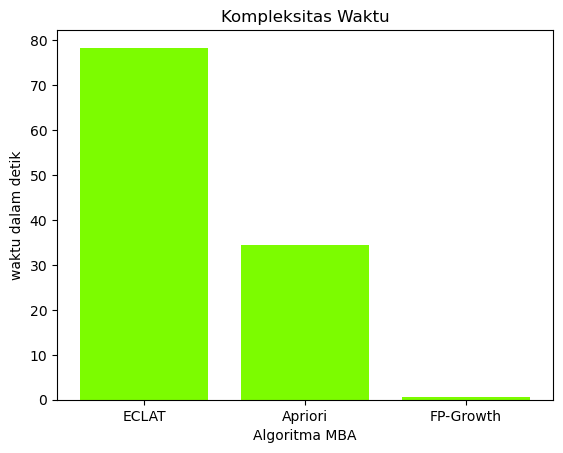

In [53]:
x = ["ECLAT", "Apriori", "FP-Growth"]
y = [waktu_eksekusi_eclat, elapsed_time_apriori, elapsed_time_fpgrowth]

plt.bar(x, y, color='#7CFC00')
plt.xlabel("Algoritma MBA")
plt.ylabel("waktu dalam detik")
plt.title("Kompleksitas Waktu")
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

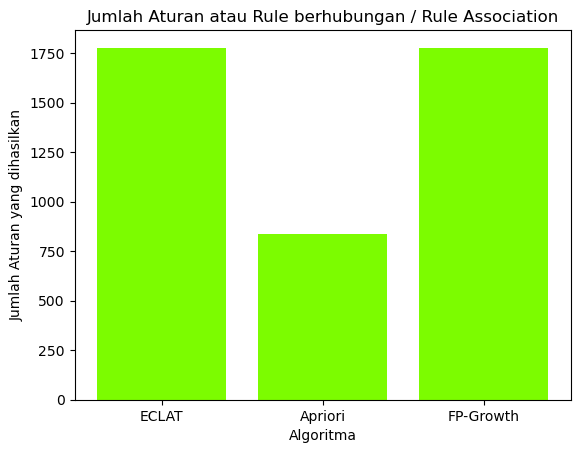

In [54]:
x = ["ECLAT", "Apriori", "FP-Growth"]
y = [len(rule_ECLAT), len(rule_APR), len(rule_FP)]

plt.bar(x, y, color='#7CFC00')
plt.xlabel("Algoritma")
plt.ylabel("Jumlah Aturan yang dihasilkan")
plt.title("Jumlah Aturan atau Rule berhubungan / Rule Association")
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

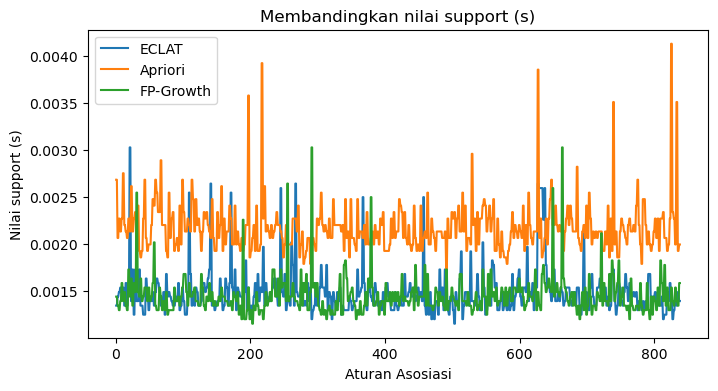

In [55]:
# Membandingkan nilai support (s) dari aturan asosiasi tiap algoritma

k   = min(len(rule_ECLAT), len(rule_APR), len(rule_FP)) # jml min aturan asosiasi yang ada
x   = [i for i in range(1, k+1)]                        # list

y1  = rule_ECLAT["support"].tail(k)
y2  = rule_APR["support"].tail(k)
y3  = rule_FP["support"].tail(k)

plt.figure(figsize=(8,4))
plt.plot(x, y1, label='ECLAT')
plt.plot(x, y2, label='Apriori')
plt.plot(x, y3, label='FP-Growth')

plt.xlabel('Aturan Asosiasi')
plt.ylabel('Nilai support (s)')
plt.title('Membandingkan nilai support (s)')

plt.legend()
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

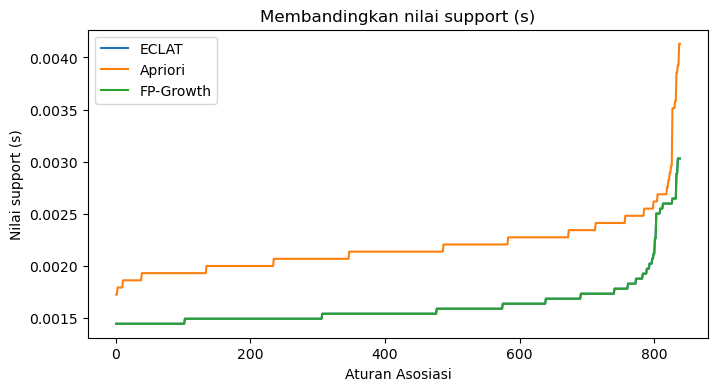

In [56]:
# Membandingkan nilai support (s) dari aturan asosiasi tiap algoritma

k   = min(len(rule_ECLAT), len(rule_APR), len(rule_FP)) # jml min aturan asosiasi yang ada
x   = [i for i in range(1, k+1)]                        # list

y1  = rule_ECLAT["support"].sort_values().tail(k)       # diurutkan terlebih dahulu, lalu ditampilkan
y2  = rule_APR["support"].sort_values().tail(k)
y3  = rule_FP["support"].sort_values().tail(k)

plt.figure(figsize=(8,4))
plt.plot(x, y1, label='ECLAT')
plt.plot(x, y2, label='Apriori')
plt.plot(x, y3, label='FP-Growth')

plt.xlabel('Aturan Asosiasi')
plt.ylabel('Nilai support (s)')
plt.title('Membandingkan nilai support (s)')

plt.legend()
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

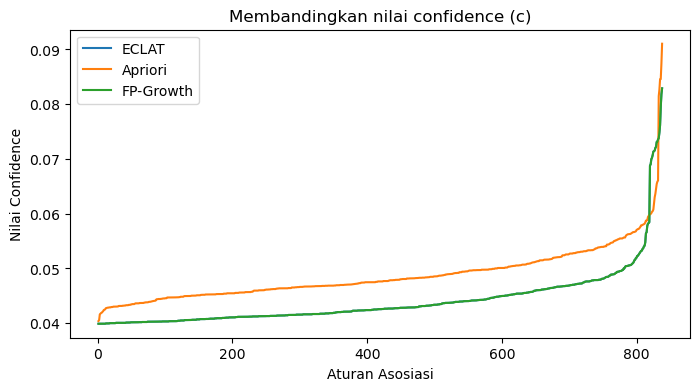

In [57]:
# Membandingkan nilai confidence (c) dari aturan asosiasi tiap algoritma

k   = min(len(rule_ECLAT), len(rule_APR), len(rule_FP)) # jml min aturan asosiasi yang ada
x   = [i for i in range(1, k+1)]                        # list

y1  = rule_ECLAT["confidence"].sort_values().tail(k)    # diurutkan terlebih dahulu, lalu ditampilkan
y2  = rule_APR["confidence"].sort_values().tail(k)
y3  = rule_FP["confidence"].sort_values().tail(k)

plt.figure(figsize=(8,4))
plt.plot(x, y1, label='ECLAT')
plt.plot(x, y2, label='Apriori')
plt.plot(x, y3, label='FP-Growth')

plt.xlabel('Aturan Asosiasi')
plt.ylabel('Nilai Confidence')
plt.title('Membandingkan nilai confidence (c)')

plt.legend()
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

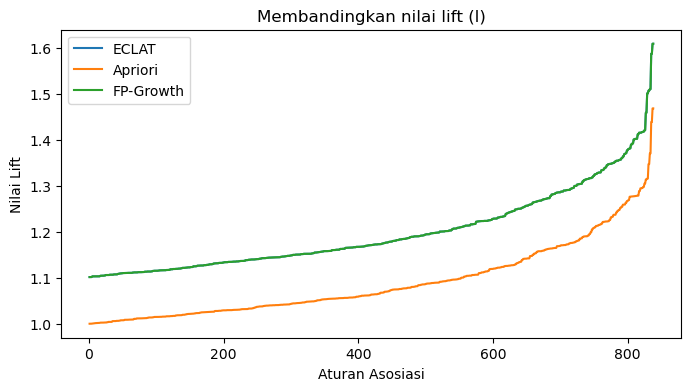

In [58]:
# Membandingkan nilai lift (l) dari aturan asosiasi tiap algoritma

k   = min(len(rule_ECLAT), len(rule_APR), len(rule_FP)) # jml min aturan asosiasi yang ada
x   = [i for i in range(1, k+1)]                        # list

y1  = rule_ECLAT["lift"].sort_values().tail(k)    # diurutkan terlebih dahulu, lalu ditampilkan
y2  = rule_APR["lift"].sort_values().tail(k)
y3  = rule_FP["lift"].sort_values().tail(k)

plt.figure(figsize=(8,4))
plt.plot(x, y1, label='ECLAT')
plt.plot(x, y2, label='Apriori')
plt.plot(x, y3, label='FP-Growth')

plt.xlabel('Aturan Asosiasi')
plt.ylabel('Nilai Lift')
plt.title('Membandingkan nilai lift (l)')

plt.legend()
plt.show()

In [59]:
# Mencari hubungan antara s, c, dan L pada suatu algoritma
custom_green_scale = [
                 [0.0, "lightgreen"],
                 [0.5, "limegreen"],
                 [1.0, "green"]
]

def banding_algoritma(rule, nama_rule):    
    fig = px.scatter(rule,
                     x     = 'support',
                     y     = 'lift',
                     color = 'confidence',
                     color_continuous_scale=custom_green_scale,
                     title = f'Hubungan antara support, confidence, dan lift dalam algoritma {nama_rule}')
    
    fig.show()

In [60]:
# Hubungan s, c, dan L pada algoritma ECLAT

banding_algoritma(rule_ECLAT, 'ECLAT')

<IPython.core.display.Javascript object>

In [61]:
# Hubungan s, c, dan L pada algoritma Apriori

banding_algoritma(rule_APR, 'Apriori')

<IPython.core.display.Javascript object>

In [62]:
# Hubungan s, c, dan L pada algoritma FP-Growth

banding_algoritma(rule_FP, 'FP-Growth')

<IPython.core.display.Javascript object>

- Algoritma ECLAT memiliki Kompleksitas waktu (detik) paling tinggi yaitu 78 jika dibandingkan dengan FP-Growth yang paling rendah yaitu 1.
- Algoritma ECLAT dan FP-Growth memiliki jumlah aturan (association rules) yang paling tinggi yaitu berkisar 1750, sedangkan Apriori 750.
- Support pada algoritma Apriori cukup besar sehingga dapat mengurangi jumlah rule yang dihasilkan, fokus pada itemset yang lebih umum dan signifikan.
- Confidence dari algoritma Apriori memiliki performa yang lebih baik dikarenakan memiliki rule yang kuat.
- Nilai lift yang ideal biasanya ada di rentang 1.2 - 1.5 hal ini dibuktikan oleh performa dari algoritma Apriori. Namun algoritma FP-Growth memiliki lift yang lebih besar sehingga menunjukkan hubungan yang lebih kuat antara itemset A dan B dibandingkan jika mereka independen.


## Evaluation Result

**FP-Growth** adalah algoritma yang memiliki performa terbaik secara keseluruhan untuk Market Basket Analysis. Waktu eksekusinya sangat cepat, menghasilkan banyak aturan yang bisa memberikan banyak wawasan, dan nilai lift yang lebih besar menunjukkan hubungan itemset yang kuat.

Namun, jikasaja ingin  mencari aturan yang lebih mudah dianalisis dan diandalkan, **Apriori** juga merupakan pilihan yang baik karena menghasilkan aturan yang lebih kuat dan signifikan dengan nilai lift dalam rentang ideal.

**ECLAT** tidak direkomendasikan jika waktu eksekusi menjadi faktor penting karena kompleksitas waktu yang tinggi.

In [65]:
items_total_bersih = df_bersih.apply(pd.Series.value_counts).sum(axis=1)
items_total_bersih = pd.DataFrame({'item': items_total_bersih.index, 'transaksi': items_total_bersih.values})

# Mendapatkan 15 produk teratas
top_15_items = items_total_bersih.sort_values('transaksi', ascending=False).head(15).reset_index(drop=True)
top_15_items.style.background_gradient(cmap='Greens')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [66]:
top_15_list = top_15_items['item'].tolist()

filtered_rules = rule_FP[rule_FP['antecedents'].apply(lambda x: any(item in x for item in top_15_list))]

# Menampilkan aturan yang relevan
filtered_rules = filtered_rules.explode('consequents')
filtered_rules['antecedents'] = filtered_rules['antecedents'].apply(lambda x: ', '.join(list(x)))
filtered_rules['consequents'] = filtered_rules['consequents'].apply(lambda x: ', '.join(list(x)))

# Visualisasi
fig = px.scatter(filtered_rules,
                 x='antecedents',
                 y='consequents',
                 size='support',
                 color='confidence',
                 color_continuous_scale='Greens',
                 title='Produk yang Sering Dibeli Setelah Top 15 Produk')
fig.update_layout(xaxis_title='Produk Teratas (Antecedents)',
                  yaxis_title='Produk yang Sering Dibeli (Consequents)',
                  xaxis_tickangle=-45)
fig.show()

<IPython.core.display.Javascript object>

**Toothbrush** dan **toothpaste** memiliki nilai confidence yang tinggi. Sehingga kedua produk tersebut sering sekali dibeli secara bersamaan. Disusul dengan Mop dan Toothpaste

### Recommendation Product

In [69]:
def rekomendasi_produk(*args):
    filtered_rules = rule_FP[rule_FP['antecedents'].apply(lambda x: all(item in x for item in args))]
    
    sorted_rules = filtered_rules.sort_values(by='confidence', ascending=False).head(10)
    
    sorted_rules['antecedents'] = sorted_rules['antecedents'].apply(lambda x: ', '.join(list(x)))
    sorted_rules['consequents'] = sorted_rules['consequents'].apply(lambda x: ', '.join(list(x)))
    
    fig = px.bar(sorted_rules,
                 x='consequents',
                 y='confidence',
                 color='confidence',
                 color_continuous_scale='Greens',
                 title=f'Rekomendasi Produk Berdasarkan Confidence untuk Produk: {", ".join(args)}')
    
    fig.update_layout(xaxis_title='Produk Rekomendasi (Consequents)',
                      yaxis_title='Confidence',
                      xaxis_tickangle=-45)
    
    fig.show()

In [70]:
rekomendasi2 = rekomendasi_produk('Carrots')
rekomendasi2

<IPython.core.display.Javascript object>

In [73]:
rekomendasi3 = rekomendasi_produk('Toothpaste')
rekomendasi3

<IPython.core.display.Javascript object>

In [74]:
file_path = 'C:/Users/ASUS/kode/projek/16. Market Basket Analysis/dataset/FP_model.pkl'

with open(file_path, 'wb') as file:
    pickle.dump(rule_FP, file)

<IPython.core.display.Javascript object>